import packages



In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


mount google drive

In [14]:
try:
    from google.colab import drive
    try:
        drive.mount('/content/drive')
    except Exception as e:
        print(f"Cannot mount Google Drive: {e}")
        print("If you're running locally, ignore this. To use Google Drive, run the notebook in Colab and authorize when prompted.")
except Exception:
    print("Google Colab not detected. Skipping drive.mount().")
    print("If you need to access Google Drive, either run this notebook in Colab or mount your drive manually.")

Google Colab not detected. Skipping drive.mount().
If you need to access Google Drive, either run this notebook in Colab or mount your drive manually.


define paths and parameters

In [15]:
# Determine environment (Google Colab vs local) and set paths accordingly
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    DEFAULT_DIR = "/content/drive/MyDrive/plankton-beans"
    DATASET_DIR = "/content/drive/MyDrive/plankton-beans/garbage-dataset"
    print("Running in Google Colab — using Google Drive paths.")
else:
    from pathlib import Path
    cwd = Path().resolve()
    candidates = [
        cwd / 'garbage-dataset',
        cwd / 'plankton-beans' / 'garbage-dataset',
        cwd.parent / 'plankton-beans' / 'garbage-dataset',
    ]
    DATASET_DIR = None
    for c in candidates:
        if c.exists():
            DATASET_DIR = str(c)
            break
    if DATASET_DIR is None:
        # Fallback: use the first candidate (may not exist) and warn the user
        DATASET_DIR = str(candidates[0])
        print(f"Warning: Dataset directory not found in standard locations. Using {DATASET_DIR}.")
        print("If this is incorrect, set DATASET_DIR manually.")
    DEFAULT_DIR = str(Path(DATASET_DIR).parent)
    print(f"Running locally. DEFAULT_DIR={DEFAULT_DIR}, DATASET_DIR={DATASET_DIR}")

IMG_SIZE = (160, 160)  # MobileNetV2 expects this size
BATCH_SIZE = 32
LR = 1e-4
VAL_SPLIT = 0.2

print("Classes:", os.listdir(DATASET_DIR) if os.path.exists(DATASET_DIR) else 'DATASET_DIR not found')

Running locally. DEFAULT_DIR=C:\Users\Germaine Denise\Downloads\plankton-beans-v2\plankton-beans, DATASET_DIR=C:\Users\Germaine Denise\Downloads\plankton-beans-v2\plankton-beans\garbage-dataset
Classes: ['nonrecyclable', 'recyclable']


generate data from 20k+ images and split them. God bless technology 🙏🙏🙏

In [16]:
gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train = gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="training"
)

val = gen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset="validation"
)

Found 15811 images belonging to 2 classes.
Found 3951 images belonging to 2 classes.


build the model with MobileNetV2

In [17]:
import os
from tensorflow.keras.models import load_model

# Paths
model_save_dir = os.path.join(DEFAULT_DIR, 'trained_models')
model_path = os.path.join(model_save_dir, 'best_model.keras')

# If you want to force retraining even when a saved model exists, set this to True
FORCE_RETRAIN = False

if not FORCE_RETRAIN and os.path.exists(model_path):
    print(f"Loading saved model from {model_path}")
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print("Loaded saved model — skipping training.")
    model.summary()
else:
    print("Building a new model (will train).")
    base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160,160,3))
    base.trainable = False  # freeze base layers

    x = GlobalAveragePooling2D()(base.output)
    out = Dense(len(train.class_indices), activation='softmax')(x)

    model = Model(base.input, out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train and save the model
    history = model.fit(
        train,
        validation_data=val,
        epochs=5,
        callbacks=callbacks,
    )
    os.makedirs(model_save_dir, exist_ok=True)
    model.save(model_path)
    print(f"Model trained and saved to {model_path}")

Loading saved model from C:\Users\Germaine Denise\Downloads\plankton-beans-v2\plankton-beans\trained_models\best_model.keras
Loaded saved model — skipping training.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

callbacks

In [18]:
import os
from tensorflow.keras.callbacks import TensorBoard

log_dir = "./logs/fit/"

model_save_dir = os.path.join(DEFAULT_DIR, 'trained_models')

callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint(os.path.join(model_save_dir, "best_model.keras"), save_best_only=True),
    TensorBoard(log_dir=log_dir, histogram_freq=1) # Log histograms of weights and biases
]

load saved model after restarting the session

In [19]:
import os
import traceback
from tensorflow.keras.models import load_model

model_save_dir = os.path.join(DEFAULT_DIR, 'trained_models')
model_path = os.path.join(model_save_dir, 'best_model.keras')

print(f"Looking for model at: {model_path}")
if not os.path.exists(model_path):
    print(f"Model file not found at {model_path}")
    if os.path.exists(model_save_dir):
        print('Files in model directory:', os.listdir(model_save_dir))
    else:
        print('Model directory does not exist:', model_save_dir)
    print('If you saved the model elsewhere, set DEFAULT_DIR or model_path accordingly.')
else:
    print('Model file exists. Size (bytes):', os.path.getsize(model_path))
    try:
        # try loading without compiling to avoid optimizer/version issues
        loaded_model = load_model(model_path, compile=False)
        print('Loaded OK; summary:')
        loaded_model.summary()
    except Exception as e:
        print('Load failed; full traceback:')
        traceback.print_exc()
        print('')
        print('Hints:')
        print('- If you used custom layers, pass them via custom_objects to load_model.')
        print('- If the error mentions SavedModel vs file, ensure the path is correct.')
        print('- Try using the same TF/Keras version used to save the model.')

Looking for model at: C:\Users\Germaine Denise\Downloads\plankton-beans-v2\plankton-beans\trained_models\best_model.keras
Model file exists. Size (bytes): 9658649
Loaded OK; summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

train the model

In [20]:
# Training is handled in the model build cell which loads a saved model if available.
# Set FORCE_RETRAIN = True in the model cell to force training.
print("Training step skipped — model already loaded or built in previous cell.")

Training step skipped — model already loaded or built in previous cell.


plot accuracy/loss

In [21]:
import matplotlib.pyplot as plt

if 'history' in globals() and hasattr(history, 'history') and history.history:
    train_acc = history.history.get('accuracy') or history.history.get('acc')
    val_acc = history.history.get('val_accuracy') or history.history.get('val_acc')
    train_loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    plt.figure(figsize=(12,5))

    # Accuracy plot (if available)
    plt.subplot(1,2,1)
    if train_acc or val_acc:
        if train_acc:
            plt.plot(train_acc, label='train')
        if val_acc:
            plt.plot(val_acc, label='val')
        plt.title("Accuracy")
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No accuracy data available', ha='center')
        plt.title('Accuracy')

    # Loss plot (if available)
    plt.subplot(1,2,2)
    if train_loss or val_loss:
        if train_loss:
            plt.plot(train_loss, label='train')
        if val_loss:
            plt.plot(val_loss, label='val')
        plt.title("Loss")
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'No loss data available', ha='center')
        plt.title('Loss')

    plt.show()
else:
    print("No training history available; skipping accuracy/loss plots.\nIf you want plots, either train the model (set FORCE_RETRAIN = True) or load a model trained in this session that produced a `history` object.")

No training history available; skipping accuracy/loss plots.
If you want plots, either train the model (set FORCE_RETRAIN = True) or load a model trained in this session that produced a `history` object.


In [22]:
import os

# 1. Define a consistent file path for validation results
results_file_path = os.path.join(DEFAULT_DIR, 'validation_results.txt')

# 2. Check if the results file exists. If it does, load val_loss and val_acc from the file.
if os.path.exists(results_file_path):
    print(f"Loading validation results from: {results_file_path}")
    with open(results_file_path, 'r') as f:
        lines = f.readlines()
        val_loss = float(lines[0].split(': ')[1])
        val_acc = float(lines[1].split(': ')[1])
    print("Loaded results — skipping model evaluation.")
else:
    # 3. If the results file does not exist, perform the model.evaluate(val) call
    print("Validation results file not found. Performing model evaluation...")
    val_loss, val_acc = model.evaluate(val)

    # 4. Save the resulting val_loss and val_acc to the file
    with open(results_file_path, 'w') as f:
        f.write(f'Validation Loss: {val_loss}\n')
        f.write(f'Validation Accuracy: {val_acc}\n')
    print(f"Validation results saved to: {results_file_path}")

# Print the val_loss and val_acc (either loaded or newly evaluated)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")


Validation results file not found. Performing model evaluation...


ImportError: This requires the scipy module. You can install it via `pip install scipy`

prediction function

In [ ]:
from tensorflow.keras.preprocessing import image

labels = {v:k for k,v in train.class_indices.items()}

def predict(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.
    x = np.expand_dims(x, axis=0)
    pred = model.predict(x)[0]
    class_id = np.argmax(pred)
    return labels[class_id], pred[class_id]

upload image file and predict (classify) image


--- Interactive Image Prediction ---
Available subcategories in 'recyclable': cardboard, clothes, glass, metal, paper, plastic, shoes

Selected image: metal_1688.jpg


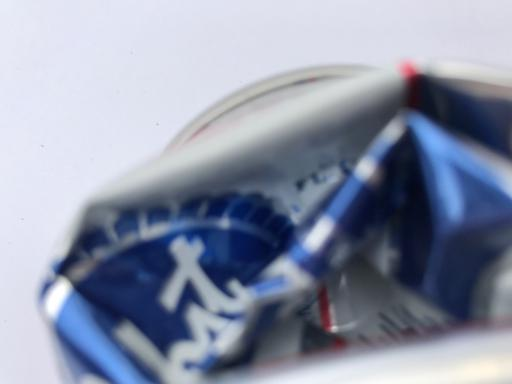

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step


KeyError: np.int64(2)

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import os

# Assuming labels and IMG_SIZE are already defined from previous cells
# labels = {v:k for k,v in train.class_indices.items()}
# IMG_SIZE = (160, 160)

def predict(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    x = image.img_to_array(img) / 255.
    x = np.expand_dims(x, axis=0)
    # Ensure 'model' is loaded in the session
    if 'model' not in globals():
        print("Model not loaded. Please ensure the model loading cell has been run.")
        return None, None
    pred = model.predict(x)[0]
    class_id = np.argmax(pred)
    return labels[class_id], pred[class_id]

print("Please upload an image file.")
uploaded = files.upload()

if uploaded:
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')
        uploaded_image_path = fn
        break # Assuming only one file is uploaded for prediction
else:
    uploaded_image_path = None
    print("No file uploaded.")

if uploaded_image_path:
    try:
        predicted_class, confidence = predict(uploaded_image_path)
        print(f"\nPrediction for '{uploaded_image_path}': {predicted_class} (Confidence: {confidence:.2f})")
    except Exception as e:
        print(f"Error predicting on uploaded image: {e}")
else:
    print("No image was uploaded for prediction.")